In [ ]:
!nvidia-smi

Fri Mar 12 03:51:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [232]:
import os
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
main_path = 'gdrive/My Drive/Colab Notebooks/DSAI_hw1'
print(os.listdir(main_path))

['本年度每日尖峰備轉容量率.csv', '台灣電力公司_過去電力供需資訊.csv']


In [257]:
df = pd.read_csv(os.path.join(main_path,'台灣電力公司_過去電力供需資訊.csv'))
df = df[['日期','備轉容量(MW)']]
df['日期'] = df['日期'].apply(str)
# print(df.head(10))
df['日期'] = pd.to_datetime(df['日期'], format='%Y%m%d')

train = df[df['日期'] <=  '2020-10-31']
valid = df[df['日期'] > '2020-10-31']
test = df[:7]
test['備轉容量(MW)'][:7] = 0

for idx in range(7):
  test['日期'][idx] = '2021-03-' + str(idx+23)

# print(train.head(10))
# print(valid.head(40))
# print(test.head(10))


# 2020 got 366 days ( @.@ )
train = train.set_index(pd.DatetimeIndex(pd.to_datetime(train['日期'])))
train = train.resample('D').sum()

valid = valid.set_index(pd.DatetimeIndex(pd.to_datetime(valid['日期'])))
valid = valid.resample('D').sum()

test = test.set_index(pd.DatetimeIndex(pd.to_datetime(test['日期'])))
test = test.resample('D').sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_ob

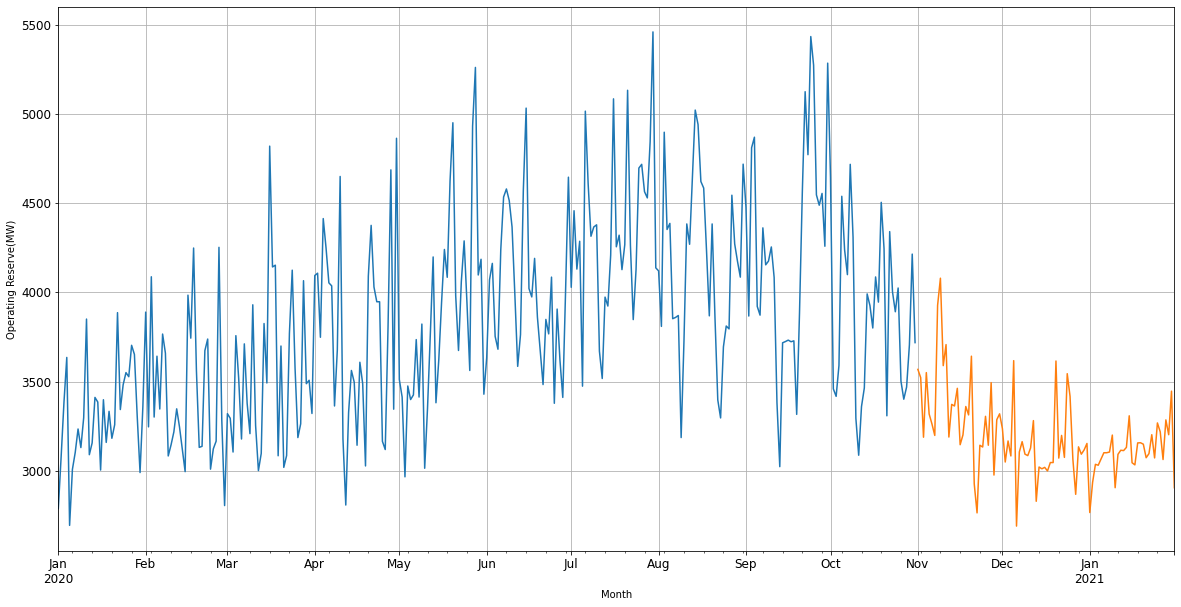

In [258]:
# Plotting data
train['備轉容量(MW)'].plot(figsize=(20, 10), fontsize=12)
valid['備轉容量(MW)'].plot(figsize=(20, 10), fontsize=12)
# test['備轉容量(MW)'].plot(figsize=(20, 10), fontsize=12)
plt.xlabel('Month')
plt.ylabel('Operating Reserve(MW)')
plt.grid(True)
plt.show()


Holt_Winter RMSE: 640.7660377733771


Model Prediction RMSE: 446.75899354439423



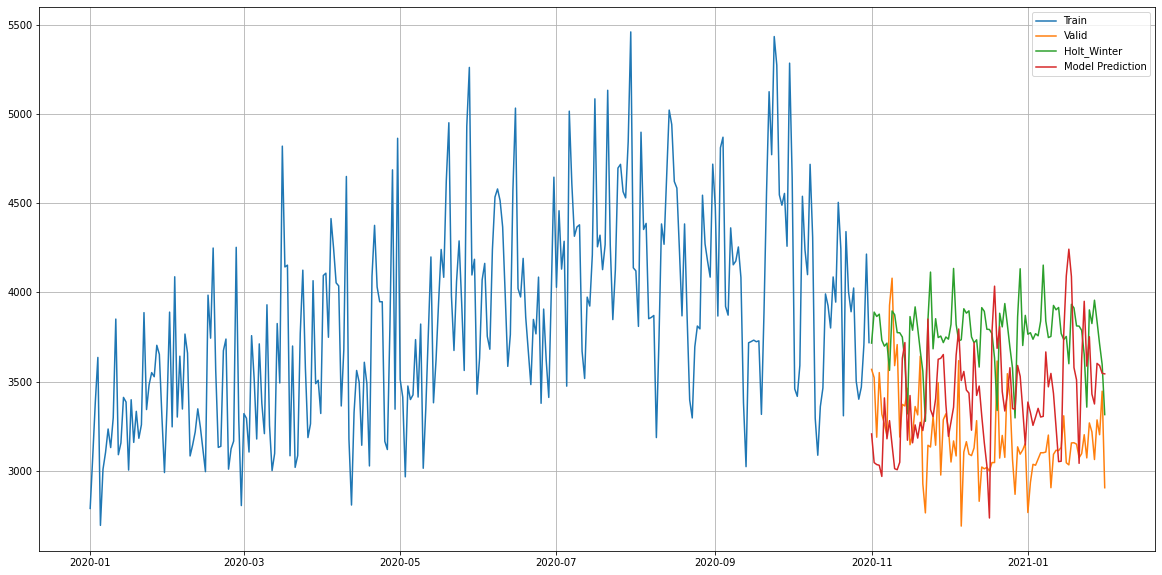

In [267]:
# Exponential Smoothing
# valid = test.copy()      <---- reactive this for apply prediction of 20210323~20210329

y_hat_avg = valid.copy()
x = valid.copy()
model = ExponentialSmoothing(np.asarray(train['備轉容量(MW)']), 
                           seasonal_periods = 35,
                           trend='add',
                           seasonal='add')
model = model.fit()
x['prediction'] =model.predict(0, len(valid)-1)
# print(x)
y_hat_avg['Holt_Winter'] = model.forecast((len(valid)))

rmse = sqrt(mean_squared_error(valid['備轉容量(MW)'], y_hat_avg['Holt_Winter']))
print("\n===========================")
print("Holt_Winter RMSE:",rmse)
print("===========================\n")

rmse = sqrt(mean_squared_error(valid['備轉容量(MW)'], x['prediction']))
print("\n===========================")
print("Model Prediction RMSE:",rmse)
print("===========================\n")

plt.figure(figsize=(20, 10))
plt.plot(train['備轉容量(MW)'], label='Train')
plt.plot(valid['備轉容量(MW)'], label='Valid')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.plot(x['prediction'], label='Model Prediction')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()



Naive Method RMSE: 573.9076296681412



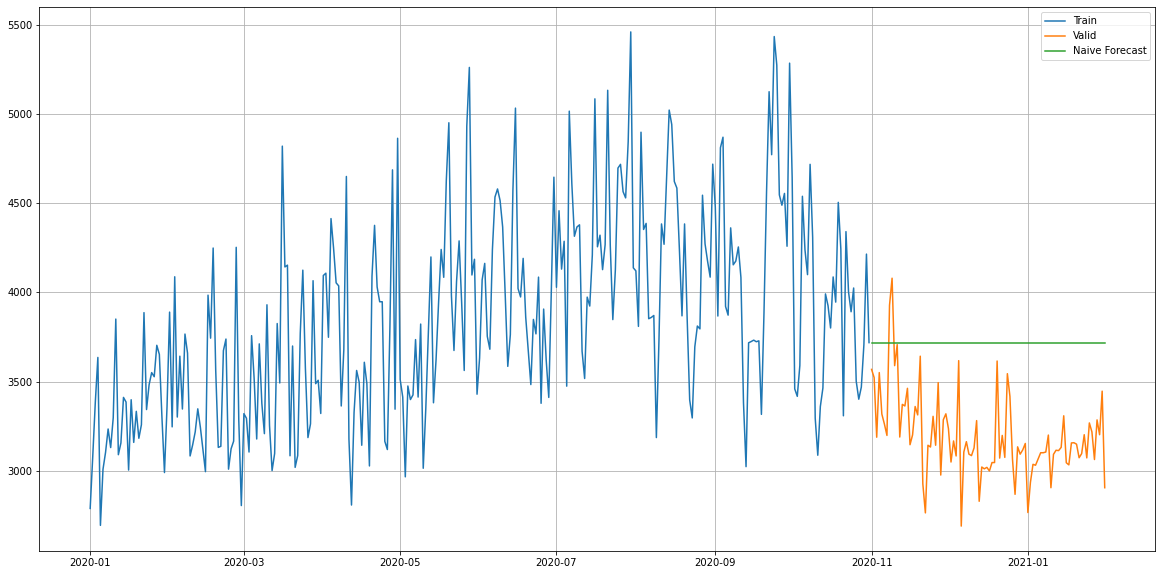

In [252]:
# Naive Method
data = np.asarray(train['備轉容量(MW)'])
y_hat = valid.copy()
y_hat['Naive'] = data[len(data)-1]

rmse = sqrt(mean_squared_error(valid['備轉容量(MW)'], y_hat['Naive']))
print("\n===========================")
print("Naive Method RMSE:",rmse)
print("===========================\n")

plt.figure(figsize=(20, 10))
plt.plot(train['備轉容量(MW)'], label='Train')
plt.plot(valid['備轉容量(MW)'], label='Valid')
plt.plot(y_hat['Naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.grid(True)


Moving Average RMSE: 929.068479608148



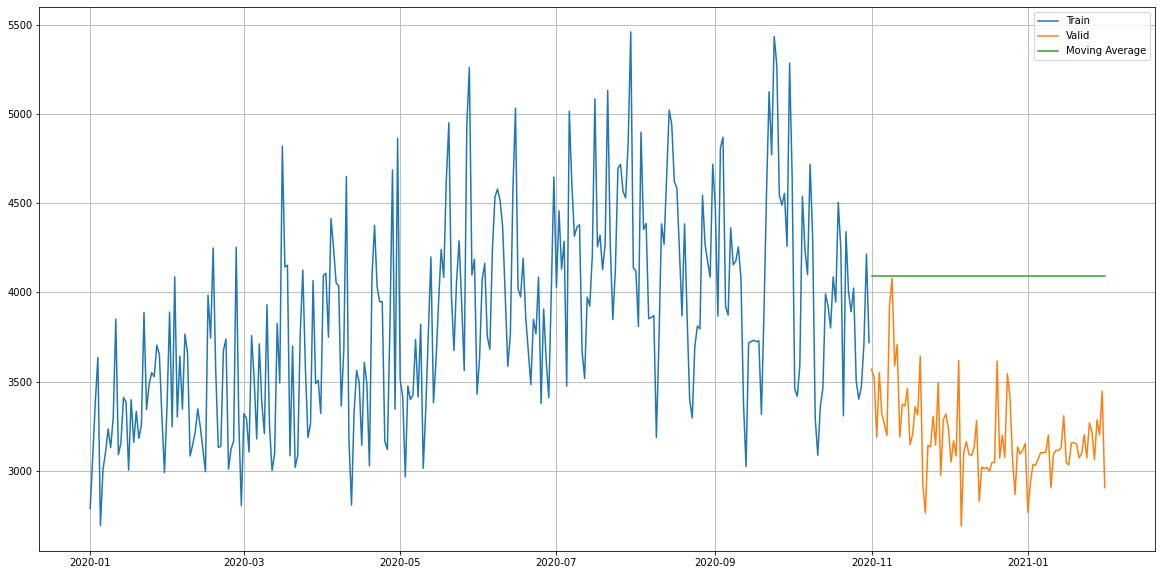

In [253]:
y_hat_avg = valid.copy()
y_hat_avg['Moving_Average'] = train['備轉容量(MW)'].rolling(90).mean().iloc[-1]

rmse = sqrt(mean_squared_error(valid['備轉容量(MW)'], y_hat_avg['Moving_Average']))
print("\n===========================")
print("Moving Average RMSE:",rmse)
print("===========================\n")

plt.figure(figsize=(20, 10))
plt.plot(train['備轉容量(MW)'], label='Train')
plt.plot(valid['備轉容量(MW)'], label='Valid')
plt.plot(y_hat_avg['Moving_Average'], label='Moving Average')
plt.legend(loc='best')
plt.grid(True)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



SARIMA RMSE: 743.2175984119621



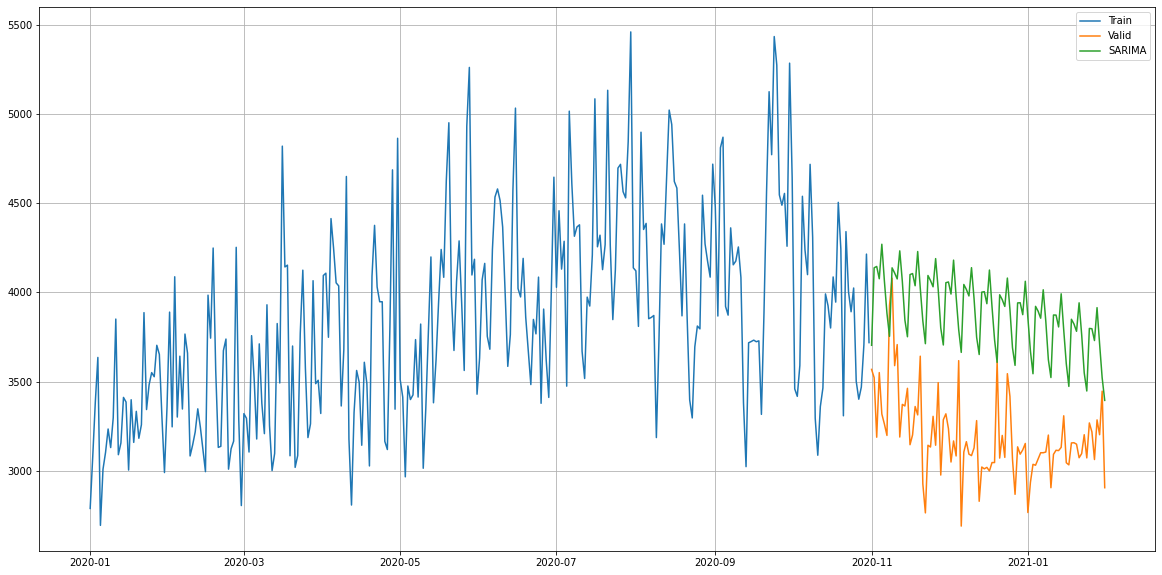

In [254]:
y_hat_avg = valid.copy()
model = sm.tsa.statespace.SARIMAX(train['備轉容量(MW)'], order=(2, 1, 4), seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_hat_avg['SARIMA'] = model.predict(start='2020-11-01', end='2021-01-31', dynamic=True)

rmse = sqrt(mean_squared_error(valid['備轉容量(MW)'], y_hat_avg['SARIMA']))
print("\n===========================")
print("SARIMA RMSE:",rmse)
print("===========================\n")

plt.figure(figsize=(20, 10))
plt.plot(train['備轉容量(MW)'], label='Train')
plt.plot(valid['備轉容量(MW)'], label='Valid')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.grid(True)
plt.show()